## Exercise

**1 - Train SARSA($\lambda$) and Q($\lambda$) agents on the Frozen Lake (FL) environment using a discount factor $\gamma=0.99$. For the comparison, you can plot only states (0, 6, 10). The optimal state-value functions is:  V(0)=0.542, V(1)=0.4988, V(2)=0.4707, V(3)=0.4569, V(4)=0.5585, V(6)=0.3583, V(8)=0.5918 , V(9)=0.6431, V(10)=0.6152, V(13)=0.7417, V(14)=0.8628 (see dynamic programming)**

Remember: FL is a simple grid-world environment. It has 16 states and 4 actions. The goal of the agent is to go from a start location to a goal location while avoiding falling into holes. All transitions landing on the goal state  provide a +1 reward, while every other transition in the entire grid world provides no reward. The challenge is that the surface of the lake is frozen, and therefore slippery. So actions have stochastic effects, and the agent moves only a third of the time as intended. The other two-thirds is split evenly in orthogonal directions.

In [1]:
optimal_V = [0.5420, 0.4988, 0.4707, 0.4569, 
             0.5585, 0.,     0.3583, 0., 
             0.5918, 0.6431, 0.6152, 0.,     
             0.,     0.7417, 0.8628, 0.] 

In [2]:
!pip install pygame

In [4]:
import gym
env = gym.make('FrozenLake-v0')

FL is a more challenging environment than SWS environment. Therefore, one of the most important changes we need to make is to increase the number of episodes the agent interacts with the environment. While in the SWS environment, we allow the agent to interact for only 2.000 episodes; in the FL environment, let your agent gather experience for 10.000 episodes.

In [10]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [11]:
import numpy as np

def sarsa_lambda(env, gamma=0.99,
                 init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
                 init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
                 lambda_=0.5, replacing_traces=True, n_episodes=10000):
    nS, nA = env.observation_space.n, env.action_space.n
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # eligibility traces to keep track of states 
    # eligible for updates
    E = np.zeros((nS, nA), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon,  epsilon_decay_ratio, n_episodes)
    
    for e in range(n_episodes):
        # every new episode, set the eligibility of every state to zero
        E.fill(0)

        # select the action of the initial state
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        
        # interaction loop
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])

            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            
            # calculate the td_error 
            td_error = td_target - Q[state][action]
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
            
            # apply the TD error to all eligible state-action pairs at once
            # even though we’re using the entire Q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            Q = Q + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            V = np.max(Q, axis=1)
            
            # update state and action for the next step
            state, action = next_state, next_action

        # save the Q-function and greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the V-function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [12]:
Q_sarsa_lambda, V_sarsa_lambda, pi_sarsa_lambda, Q_track_sarsa_lambda, V_track_sarsa_lambda, pi_track_sarsa_lambda = sarsa_lambda(env)

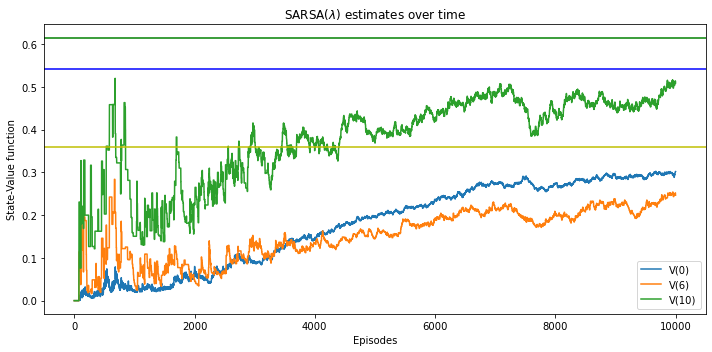

In [14]:
import matplotlib.pyplot as plt

legends = ['V(0)','V(6)','V(10)']

plt.figure(figsize=(10,5))
plt.plot(V_track_sarsa_lambda[:,[0,6,10]])
plt.axhline(y=optimal_V[0], color='b', linestyle='-')
plt.axhline(y=optimal_V[6], color='y', linestyle='-')
plt.axhline(y=optimal_V[10], color='g', linestyle='-')
plt.title('SARSA($\lambda$) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

Look at the SARSA($\lambda$) agent struggle to estimate the optimal state-value function. 

In [15]:
def q_lambda(env, gamma=0.99,
             init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
             init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
             lambda_=0.5, replacing_traces=True, n_episodes=10000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
        
    E = np.zeros((nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    for e in range(n_episodes):
        E.fill(0)
        
        state, done = env.reset(), False
        
        # notice: we are preselecting the action as in SARSA, 
        # but we didn’t do that in Q-learning. 
        # this is because we need to check whether our next action is greedy!
        action = select_action(state, Q, epsilons[e])
        
        while not done:
            
            next_state, reward, done, _ = env.step(action)
            
            # select the next_action SARSA-style
            next_action = select_action(next_state, Q, epsilons[e])
            
            # use it to verify that the action on the next step 
            # will still come from the greedy policy
            next_action_is_greedy = Q[next_state][next_action] == Q[next_state].max()

            # still calculate the TD target as in regular Q-learning, using the max.
            td_target = reward + gamma * Q[next_state].max() * (not done)
            
            # and use the TD target to calculate the TD error.
            td_error = td_target - Q[state][action]
            
            if replacing_traces: E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
            
            # as before, we multiply the entire eligibility trace matrix 
            # by the error and the learning rate corresponding to episode e, 
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # notice: if the action we’ll take on the next state 
            # (which we already selected) is a greedy action, then we decay 
            # the eligibility matrix as usual, otherwise, we must reset 
            # the eligibility matrix to zero because we’ll no longer be learning 
            # about the greedy policy.
            if next_action_is_greedy:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [16]:
_q_lambda, V_q_lambda, pi_q_lambda, Q_track_q_lambda, V_track_q_lambda, pi_track_q_lambda = q_lambda(env)

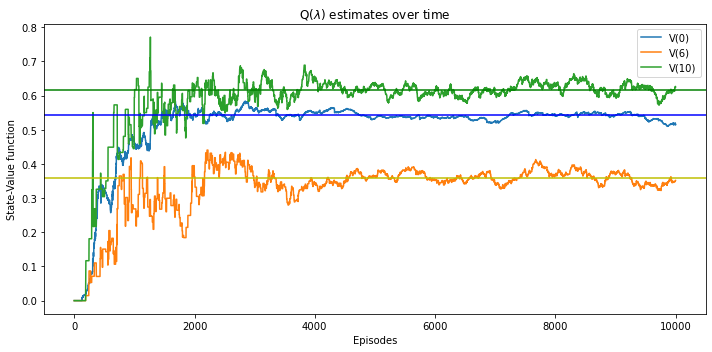

In [17]:
plt.figure(figsize=(10,5))
plt.plot(V_track_q_lambda[:,[0,6,10]])
plt.axhline(y=optimal_V[0], color='b', linestyle='-')
plt.axhline(y=optimal_V[6], color='y', linestyle='-')
plt.axhline(y=optimal_V[10], color='g', linestyle='-')
plt.title('Q($\lambda$) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

The Q($\lambda$) agent is moving the estimates of the optimal state-value function toward the true values, unlike SARSA($\lambda$). Now, to be clear, this is a matter of the number of steps, also SARSA($\lambda$) would converge to the true values if given more episodes.

**2 - Now train DynaQ and Trajectory samplig agents on the environment**

In [18]:
def dyna_q(env, gamma=1.0,
           init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
           init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
           n_planning=3, n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # create a function to keep track of the transition function.
    # and another one to keep track of the reward signal.
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=np.float64)
    T_track, R_track, planning_track = [], [], []
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    # the episode loop
    for e in range(n_episodes):
                   
        state, done = env.reset(), False
        
        while not done:
                   
            # select the action, as in original Q-learning       
            action = select_action(state, Q, epsilons[e])
                   
            # step the environment and get the experience tuple
            next_state, reward, done, _ = env.step(action)

            # start learning the model! 
            # increment the transition count for the state-action-next_state triplet 
            T_count[state][action][next_state] += 1
            
            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            # calculate the TD target as usual, Q-learning style 
            # (off-policy, using the max)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            
            # and the TD error
            td_error = td_target - Q[state][action]
            
            # finally, update the Q-function
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            # get into the planning steps, first back up the next state variable.       
            backup_next_state = next_state
            
            # planning loop
            for _ in range(n_planning):
                   
                # make sure there have been updates to the Q-function before, 
                # otherwise, there’s not much to plan
                if Q.sum() == 0: break

                # select a state from a list of states already visited by 
                # the agent in experience   
                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                state = np.random.choice(visited_states)

                # then select an action that has been taken on that state.   
                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                # use the count matrix to calculate probabilities of a next state 
                # and then a next state   
                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                
                # use the reward model as the reward
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                # update the Q-function using that simulated experience!    
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            V = np.max(Q, axis=1)
            
            # at the end of the planning steps, set the state as the next state
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

In [19]:
def trajectory_sampling(env, gamma=1.0,
                        init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
                        init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
                        max_trajectory_depth=100, planning_freq=5,
                        greedy_planning=True, n_episodes=2000):
            
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=np.float64)
    T_track, R_track, planning_track = [], [], []
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    for e in range(n_episodes):
                   
        state, done = env.reset(), False

        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            backup_next_state = next_state

            if e % planning_freq == 0:
                
                # notice: start planning using max_trajectory_depth variable
                # insted of n_planning
                for _ in range(max_trajectory_depth):
                    if Q.sum() == 0: break

                    # select the action either on-policy or off-policy 
                    action = Q[state].argmax() if greedy_planning else \
                        select_action(state, Q, epsilons[e])
                    
                    # if we haven’t experienced the transition, 
                    # planning would be a mess, so break out
                    if not T_count[state][action].sum(): break

                    # otherwise, get the probabilities of next_state and sample 
                    # the model accordingly, as in DynaQ
                    probs = T_count[state][action]/T_count[state][action].sum()
                    next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                    
                    # get the reward as prescribed by the reward-signal model, as in DynaQ
                    reward = R_model[state][action][next_state]
                    planning_track.append((state, action, reward, next_state))

                    
                    # continue updating the Q-function as if with real experience, as in DynaQ
                    td_target = reward + gamma * Q[next_state].max()
                    td_error = td_target - Q[state][action]
                    Q[state][action] = Q[state][action] + alphas[e] * td_error

                    # notice: we update the state variable before we loop and 
                    # continue the on-policy planning steps
                    state = next_state

            V = np.max(Q, axis=1)
            
            # outside the planning loop, we restore the state, 
            # and continue real interaction steps
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

In [20]:
Q_dyna, V_dyna, pi_dyna, Q_track_dq, V_track_dq, pi_track_dq, T_track_dq, R_track_dq, planning_dq = dyna_q(env, gamma=0.99, n_episodes=10000)

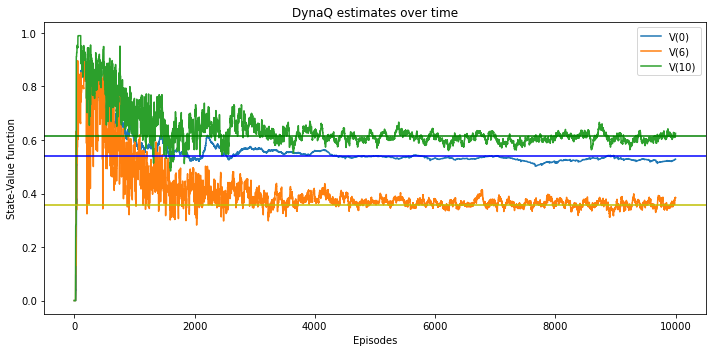

In [22]:
plt.figure(figsize=(10,5))
plt.plot(V_track_dq[:,[0,6,10]])
plt.axhline(y=optimal_V[0], color='b', linestyle='-')
plt.axhline(y=optimal_V[6], color='y', linestyle='-')
plt.axhline(y=optimal_V[10], color='g', linestyle='-')
plt.title('DynaQ estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

The Dyna-Q agent is even faster than the Q($\lambda$) agent at tracking the true values, but notice too, how there’s a large error spike at the beginning of training. This is likely because the model is incorrect early on, and Dyna-Q randomly samples states from the learned model, even states not sufficiently visited.

In [23]:
Q_ts, V_ts, pi_ts, Q_track_ts, V_track_ts, pi_track_ts, T_track_ts, R_track_ts, planning_ts = trajectory_sampling(env, gamma=0.99, n_episodes=10000)

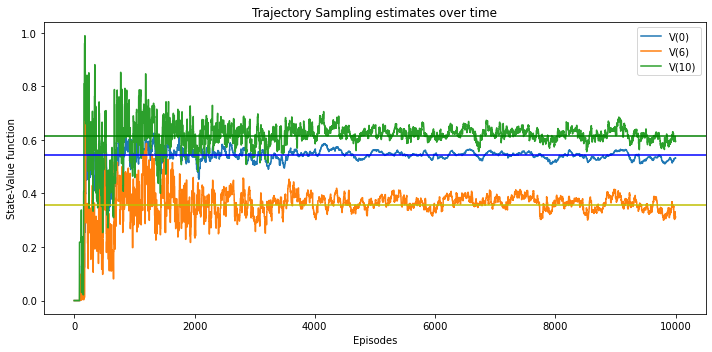

In [25]:
plt.figure(figsize=(10,5))
plt.plot(V_track_ts[:,[0,6,10]])
plt.axhline(y=optimal_V[0], color='b', linestyle='-')
plt.axhline(y=optimal_V[6], color='y', linestyle='-')
plt.axhline(y=optimal_V[10], color='g', linestyle='-')
plt.title('Trajectory Sampling estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

The trajectory sampling agent uses the greedy trajectory, so the agent samples states likely to be encountered; perhaps, the reason why there’s more stability in TS.

**3 - Plot the action-value function mean absolute error for all methods**

In [26]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

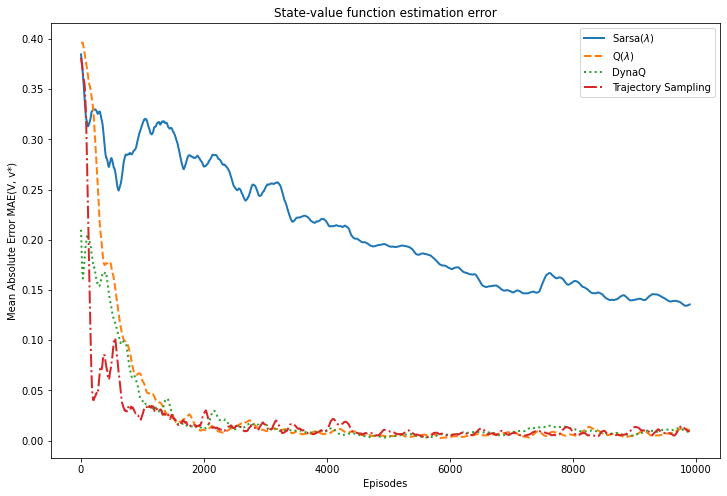

In [27]:
plt.figure(figsize=(12,8))

plt.plot(moving_average(np.mean(np.abs(V_track_sarsa_lambda - optimal_V), axis=1)), '-', linewidth=2, label='Sarsa($\lambda$)')
plt.plot(moving_average(np.mean(np.abs(V_track_q_lambda - optimal_V), axis=1)), '--', linewidth=2, label='Q($\lambda$)')
plt.plot(moving_average(np.mean(np.abs(V_track_dq - optimal_V), axis=1)), ':', linewidth=2, label='DynaQ')
plt.plot(moving_average(np.mean(np.abs(V_track_ts - optimal_V), axis=1)), '-.', linewidth=2, label='Trajectory Sampling')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')

plt.show()

As we can see, the model-based methods also bring the error down close to zero, which is the fastest. However, shortly after 2,000 episodes, both model-based and Q($\lambda$) methods are much the same. SARSA($\lambda$) methods are also slow to optimal here.